In [1]:
import torch
import torch.nn as nn   
import torch.hub
from efficientnet_pytorch import EfficientNet
from torchvision.models import efficientnet_b0, densenet161, resnet50

import torch.optim as optim
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from collections import OrderedDict

from torch.utils.data import DataLoader
from transformations import CustomDataset
from transformations import augment, augment_fair1m, reshape_features
from visuals import gradcam, confusion, learning_curves, show_images_with_labels

import pandas as pd
import pickle
from sklearn.metrics import f1_score
from tree import kdtree, search

# set the device we will be using to train the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

/Users/constantinosazas/CV_ML_Assignment/interview_datasets/RESISC45_partial/airplane/airplane_079.jpg


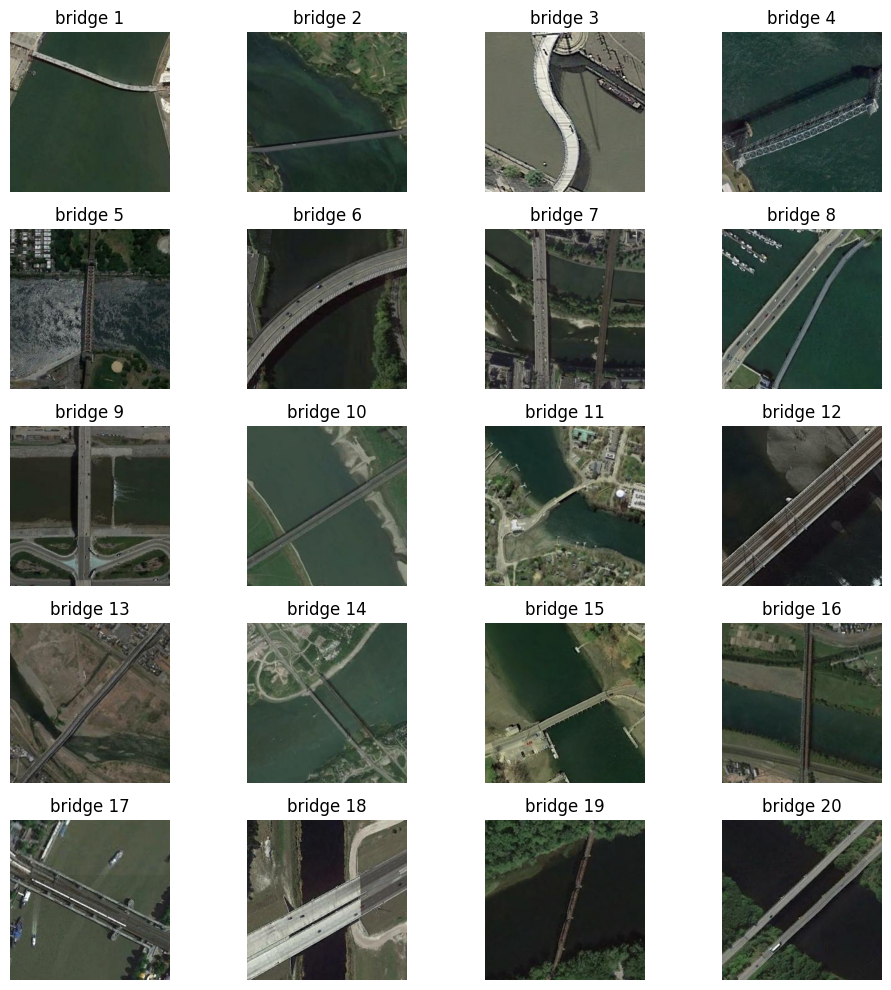

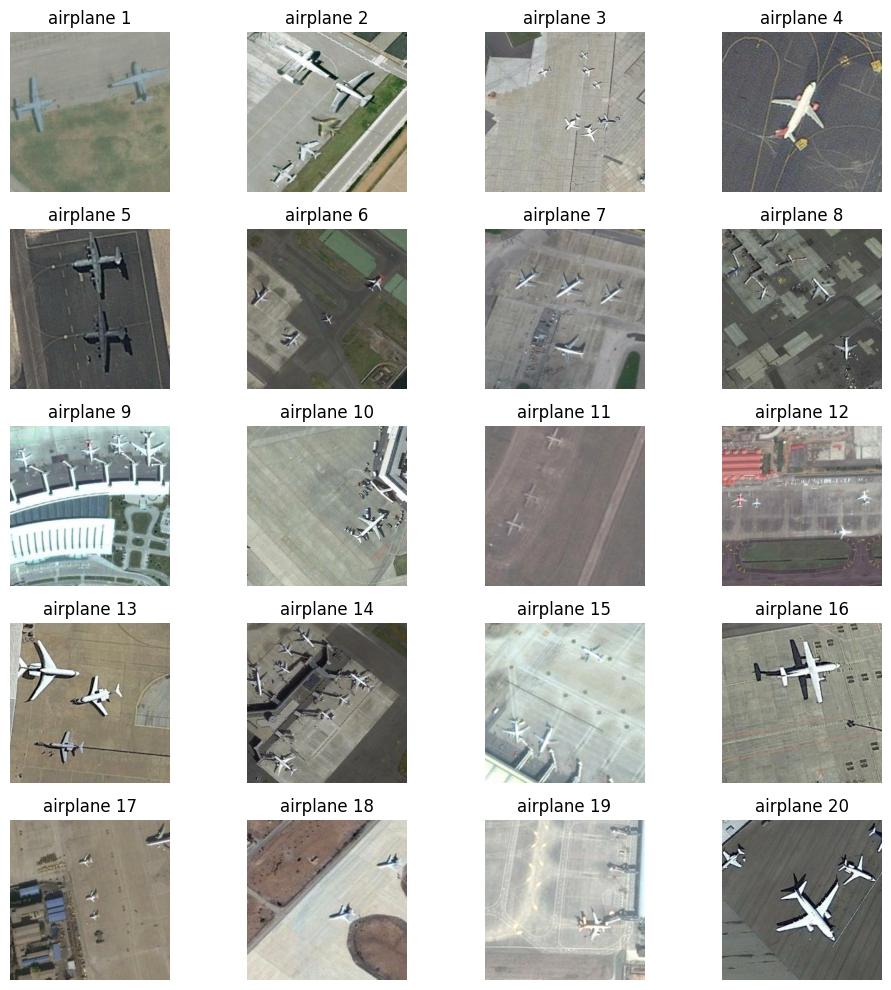

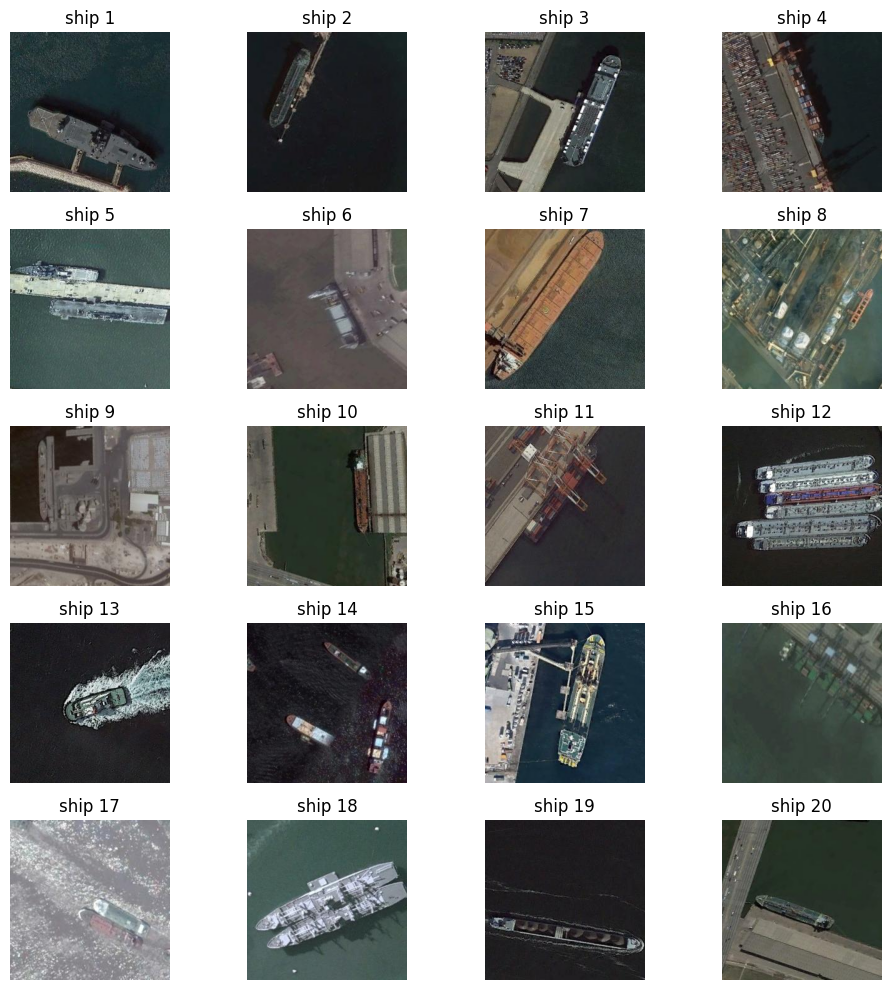

In [104]:
# data analysis for RESISC_45

# List of image file paths and corresponding labels
image_dir = "/Users/constantinosazas/CV_ML_Assignment/interview_datasets/RESISC45_partial"

# display a grid of images with respective labels
show_images_with_labels(image_dir)

In [28]:
# FAIR1M

train_df = pd.read_csv('/Users/constantinosazas/CV_ML_Assignment/data_preprocessed/FAIR1M_partial/train.csv')
val_df = pd.read_csv('/Users/constantinosazas/CV_ML_Assignment/data_preprocessed/FAIR1M_partial/val.csv')
test_df = pd.read_csv('/Users/constantinosazas/CV_ML_Assignment/data_preprocessed/FAIR1M_partial/test.csv')

# data augmentation
transforms_train, transforms_val = augment_fair1m(desired_size = (1000, 1000, 3))

batch_size = 8

train_df["Labels"][train_df["Labels"] == "Neighborhood"]= 0
train_df["Labels"][train_df["Labels"] == "Airplane"] = 1
train_df["Labels"][train_df["Labels"] == "Ship"] = 2

val_df["Labels"][val_df["Labels"] == "Neighborhood"] = 0
val_df["Labels"][val_df["Labels"] == "Airplane"] = 1
val_df["Labels"][val_df["Labels"] == "Ship"]= 2

test_df["Labels"][test_df["Labels"] == "Neighborhood"] = 0
test_df["Labels"][test_df["Labels"] == "Airplane"]= 1
test_df["Labels"][test_df["Labels"] == "Ship"] = 2

# Create data loaders
train_loader = DataLoader(CustomDataset(train_df, transform=transforms_train), batch_size=batch_size, shuffle=False)
val_loader = DataLoader(CustomDataset(val_df, transform=transforms_val), batch_size=batch_size, shuffle=False)
test_loader = DataLoader(CustomDataset(test_df, transform=transforms_val), batch_size=batch_size, shuffle=False)

/var/folders/n3/536s1j3s5p54fvlgzptn4k4w0000gn/T/ipykernel_14220/4255336399.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df["Labels"][train_df["Labels"] == "Neighborhood"]= 0
/var/folders/n3/536s1j3s5p54fvlgzptn4k4w0000gn/T/ipykernel_14220/4255336399.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df["Labels"][train_df["Labels"] == "Airplane"] = 1
/var/folders/n3/536s1j3s5p54fvlgzptn4k4w0000gn/T/ipykernel_14220/4255336399.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/

In [2]:
batch_size = 18
train_df = pd.read_csv('/Users/constantinosazas/CV_ML_Assignment/data_preprocessed/Sentinel2_partial/train.csv')
val_df = pd.read_csv('/Users/constantinosazas/CV_ML_Assignment/data_preprocessed/Sentinel2_partial/val.csv')
test_df = pd.read_csv('/Users/constantinosazas/CV_ML_Assignment/data_preprocessed/Sentinel2_partial/test.csv')

# train_df["Labels"][train_df["Labels"] == "bridge"]= 0
# train_df["Labels"][train_df["Labels"] == "airplane"] = 1
# train_df["Labels"][train_df["Labels"] == "ship"] = 2

# val_df["Labels"][val_df["Labels"] == "bridge"] = 0
# val_df["Labels"][val_df["Labels"] == "airplane"] = 1
# val_df["Labels"][val_df["Labels"] == "ship"]= 2

# test_df["Labels"][test_df["Labels"] == "bridge"] = 0
# test_df["Labels"][test_df["Labels"] == "airplane"]= 1
# test_df["Labels"][test_df["Labels"] == "ship"] = 2

train_df["Labels"][train_df["Labels"] == "NoShip"]= 0
train_df["Labels"][train_df["Labels"] == "Ship"] = 1

val_df["Labels"][val_df["Labels"] == "NoShip"] = 0
val_df["Labels"][val_df["Labels"] == "Ship"] = 1

test_df["Labels"][test_df["Labels"] == "NoShip"] = 0
test_df["Labels"][test_df["Labels"] == "Ship"]= 1

# data augmentation
transforms_train, transforms_val = augment()

# Create data loaders
train_loader = DataLoader(CustomDataset(train_df, transform=transforms_train), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(CustomDataset(val_df, transform=transforms_val), batch_size=batch_size, shuffle=True)
test_loader = DataLoader(CustomDataset(test_df, transform=transforms_val), batch_size=batch_size, shuffle=True)

/var/folders/n3/536s1j3s5p54fvlgzptn4k4w0000gn/T/ipykernel_65161/3705584420.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df["Labels"][train_df["Labels"] == "NoShip"]= 0
/var/folders/n3/536s1j3s5p54fvlgzptn4k4w0000gn/T/ipykernel_65161/3705584420.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df["Labels"][train_df["Labels"] == "Ship"] = 1
/var/folders/n3/536s1j3s5p54fvlgzptn4k4w0000gn/T/ipykernel_65161/3705584420.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/use

In [19]:
model_path = '/Users/constantinosazas/CV_ML_Assignment/models/resisc45_scratch_resnet50.pth.tar'

# Load the model
model_checkpoint = torch.load(model_path, map_location=torch.device('cpu'))

# models
model = EfficientNet.from_pretrained('efficientnet-b0', num_classes = 2)  
# model = resnet50(num_classes = 45)

new_dict = {}
for old_key, new_key in zip(model_checkpoint['state_dict'].keys(), model.state_dict().keys()):
    value = model_checkpoint['state_dict'][old_key]
    new_dict[new_key] = value

model_checkpoint['state_dict'] = OrderedDict(new_dict)
model.load_state_dict(model_checkpoint['state_dict'])

# Freeze layers (EfficientNet-b0)
for param in model._fc.parameters():
    param.requires_grad = False


# Freeze layers (ResNet-50)
# for param in model.fc.parameters():
#     param.requires_grad = False

# for param in model.layer4.parameters():
#     param.requires_grad = False

# Build feature_extractor by manually selecting desired layers
# feature_extractor = nn.Sequential(*list(model.children())[:-2])

num_classes = 2

model._fc = nn.Linear(model._fc.in_features, num_classes) # EfficientNet-b0

# model.fc = nn.Linear(model.fc.in_features, num_classes) # ResNet50

num_features = model._fc.in_features # EfficientNet-b0

# num_features = model.fc.in_features # ResNet50

# multi-class activation
if num_classes == 3:
    
    new_fc = nn.Sequential(
        nn.Linear(num_features, num_classes),
        nn.Softmax(dim = 1)
    )

# binary activation
else:
    new_fc = nn.Sequential(
        nn.Linear(num_features, num_classes),
        nn.Sigmoid()
    )

model._fc = new_fc
# model.fc = new_fc

Loaded pretrained weights for efficientnet-b0


In [6]:
# Initialise the loss function
lossFn = nn.CrossEntropyLoss()

# Initialise the optimiser
optimizer = optim.Adam(model.parameters(), lr=0.001)

# initialize a dictionary to store training history
H = {
	"train_loss": [],
	"train_acc": [],
    "train_f1": [],
	"val_loss": [],
	"val_acc": [],
    "val_f1": []
}


# parameters/hyperparameters
epochs = 10
batch_size = 8

epochs_without_improvement = 0
patience = 5
best_val_loss = float('inf')


# calculate steps per epoch for training and validation set
trainSteps = len(train_loader.dataset) // batch_size
valSteps = len(val_loader.dataset) // batch_size

In [27]:
from torchsummary import summary

summary(model, input_size=(3, 1000, 1000))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 500, 500]           9,408
       BatchNorm2d-2         [-1, 64, 500, 500]             128
              ReLU-3         [-1, 64, 500, 500]               0
         MaxPool2d-4         [-1, 64, 250, 250]               0
            Conv2d-5         [-1, 64, 250, 250]           4,096
       BatchNorm2d-6         [-1, 64, 250, 250]             128
              ReLU-7         [-1, 64, 250, 250]               0
            Conv2d-8         [-1, 64, 250, 250]          36,864
       BatchNorm2d-9         [-1, 64, 250, 250]             128
             ReLU-10         [-1, 64, 250, 250]               0
           Conv2d-11        [-1, 256, 250, 250]          16,384
      BatchNorm2d-12        [-1, 256, 250, 250]             512
           Conv2d-13        [-1, 256, 250, 250]          16,384
      BatchNorm2d-14        [-1, 256, 2

In [31]:
# loop over our epochs
for e in range(0, epochs):

	# set the model in training mode
	model.train()

	# initialize the total training and validation loss
	totalTrainLoss = 0
	totalValLoss = 0

	# initialize the number of correct predictions in the training and validation step
	trainCorrect = 0
	valCorrect = 0

	# initialize the f1-score in the training and validation step
	f1_train = []
	f1_val = []

	# loop over the training set
	for (x, y) in train_loader:
		# perform a forward pass and calculate the training loss
		pred = model(x)
		loss = lossFn(pred, y)

		# zero out the gradients, perform the backpropagation step and update the weights
		optimizer.zero_grad()
		loss.backward()
		optimizer.step()

		# add the loss to the total training loss so far and calculate the number of correct predictions, f-1 score
		totalTrainLoss += loss
		trainCorrect += (pred.argmax(1) == y).type(
			torch.float).sum().item()
		
		f1_train.append(f1_score(y.cpu().numpy(), pred.argmax(1).cpu().numpy(), average='weighted'))
		
		# switch off autograd for evaluation
	with torch.no_grad():
		# set the model in evaluation mode
		model.eval()
		
		# loop over the validation set
		for (x, y) in val_loader:
			# make the predictions and calculate the validation loss
			pred = model(x)
			totalValLoss += lossFn(pred, y)

			# calculate the number of correct predictions
			valCorrect += (pred.argmax(1) == y).type(
				torch.float).sum().item()
			
			f1_val.append(f1_score(y.cpu().numpy(), pred.argmax(1).cpu().numpy(), average='weighted'))
	
	# calculate the average training and validation loss
	avgTrainLoss = totalTrainLoss / trainSteps
	avgValLoss = totalValLoss / valSteps

	# calculate the training and validation accuracy
	trainCorrect = (trainCorrect / len(train_loader.dataset)) * 100
	valCorrect = (valCorrect / len(val_loader.dataset)) * 100

	# calculate the f-1 scores
	f1_train = np.mean(f1_train)
	f1_val = np.mean(f1_val)

	# update our training history
	H["train_loss"].append(avgTrainLoss.cpu().detach().numpy())
	H["train_acc"].append(trainCorrect)
	H["train_f1"].append(f1_train)
	H["val_loss"].append(avgValLoss.cpu().detach().numpy())
	H["val_acc"].append(valCorrect)
	H["val_f1"].append(f1_val)
	
	# print the model training and validation information
	print("[INFO] EPOCH: {}/{}".format(e + 1, epochs))
	print("Train loss: {:.6f}, Train accuracy: {:.4f} %".format(
		avgTrainLoss, trainCorrect))
	print("Val loss: {:.6f}, Val accuracy: {:.4f} %\n".format(
		avgValLoss, valCorrect))
	
	# saving the model weights based on validation performance
	torch.save(model.state_dict(), f"weights/FAIR_1M/ResNet/model_weights_epoch{e + 1}.pth.tar")

	# Check for early stopping
	if avgValLoss < best_val_loss:
		best_val_loss = avgValLoss
		epochs_without_improvement = 0
		
	else:
		epochs_without_improvement += 1

	if epochs_without_improvement >= patience:
		print(f"Early stopping after {e + 1} epochs without improvement.")
		break

# save the history
file_name = 'weights/FAIR_1M/ResNet/history.pkl'

with open(file_name, 'wb') as file:
	pickle.dump(H, file)

# feature_extractor = model.extract_features # EfficientNet-b0
feature_extractor = torch.nn.Sequential(*list(model.children())[:-2]) #ResNet-50
# feature_extractor = model.features # DenseNet-161

# turn off autograd for testing evaluation
with torch.no_grad():
	# set the model in evaluation mode
	model.eval()
	
	# initialize a list to store our predictions
	preds = []
	feature_vectors = []

	# loop over the test set
	for (x, y) in test_loader:
		# make the predictions and add them to the list
		pred = model(x)
		preds.extend(pred.argmax(axis=1).cpu().numpy())
		feature_vectors.extend(feature_extractor(x))
		
	feature_vectors = torch.stack(feature_vectors)

[INFO] EPOCH: 1/10
Train loss: 1.536775, Train accuracy: 18.5185 %
Val loss: 1.952153, Val accuracy: 33.3333 %

[INFO] EPOCH: 2/10
Train loss: 1.405597, Train accuracy: 33.3333 %
Val loss: 1.952167, Val accuracy: 33.3333 %

[INFO] EPOCH: 3/10
Train loss: 1.355550, Train accuracy: 33.3333 %
Val loss: 1.951804, Val accuracy: 33.3333 %

[INFO] EPOCH: 4/10
Train loss: 1.271758, Train accuracy: 37.0370 %
Val loss: 1.868470, Val accuracy: 33.3333 %

[INFO] EPOCH: 5/10
Train loss: 1.260154, Train accuracy: 37.0370 %
Val loss: 1.554481, Val accuracy: 33.3333 %

[INFO] EPOCH: 6/10
Train loss: 1.213987, Train accuracy: 44.4444 %
Val loss: 1.551996, Val accuracy: 33.3333 %

[INFO] EPOCH: 7/10
Train loss: 1.184637, Train accuracy: 48.1481 %
Val loss: 1.506543, Val accuracy: 44.4444 %

[INFO] EPOCH: 8/10
Train loss: 1.169528, Train accuracy: 50.0000 %
Val loss: 1.494259, Val accuracy: 33.3333 %

[INFO] EPOCH: 9/10
Train loss: 1.158213, Train accuracy: 53.7037 %
Val loss: 1.498225, Val accuracy: 44.

In [7]:
# draw the learning curves

file_name = 'weights/RESISC_45/ResNet/history.pkl'

with open(file_name, 'rb') as file:
    H = pickle.load(file)

learning_curves(H)

<Figure size 640x480 with 0 Axes>

In [ ]:
# obtain predictions for confusion matrix
with torch.no_grad():
	
	# set the model in evaluation mode
	model.eval()
	
	# initialize a list to store our predictions
	preds = []

	# loop over the test set
	for x, y in test_loader:
		pred = model(x)
		preds.extend(pred.argmax(axis=1).cpu().numpy())

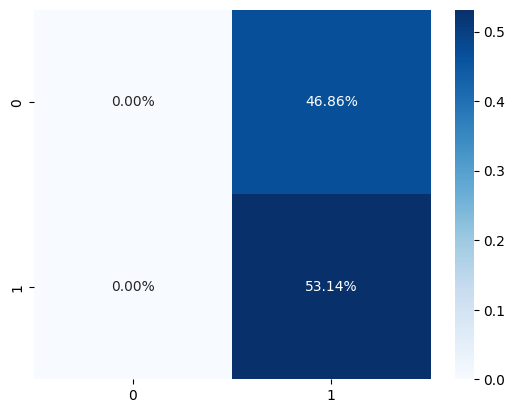

In [24]:
# confusion matrix

y_true = [test_loader.dataset[y][1] for y in range(len(test_loader.dataset))]

confusion(y_true, preds)

In [9]:
# Tree creation
kdtree(feature_vectors) # EfficientNet

In [38]:
# Loading EfficientNet
model_path = "weights/Sentinel2/EfficientNet/model_weights_epoch6.pth.tar"

# Load the model
model_checkpoint = torch.load(model_path, map_location=torch.device('cpu'))

# models
model = EfficientNet.from_pretrained('efficientnet-b0', num_classes = 2)  

new_dict = {}
for old_key, new_key in zip(model_checkpoint.keys(), model.state_dict().keys()):
    value = model_checkpoint[old_key]
    new_dict[new_key] = value

model_checkpoint['state_dict'] = OrderedDict(new_dict)
model.load_state_dict(model_checkpoint['state_dict'])

Loaded pretrained weights for efficientnet-b0


<All keys matched successfully>

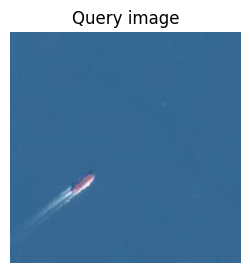

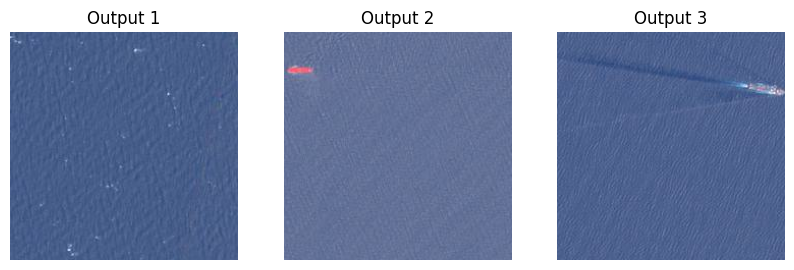

In [39]:
# EfficientNet on Sentinel_2 EXAMPLE 1
path = "interview_datasets/Sentinel2_partial/Ship/0_1_2_3_id_1272.jpg"
search(path, "kd_tree.pkl", model, test_loader) 

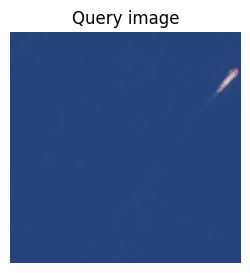

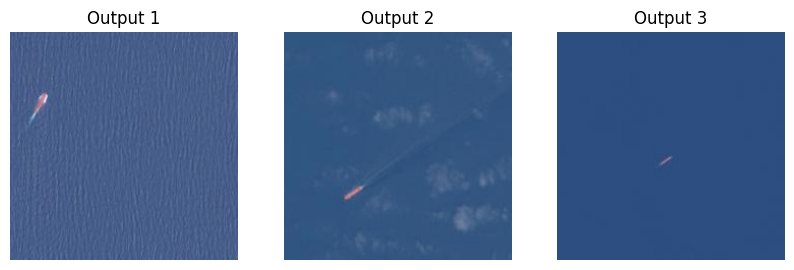

In [57]:
# EfficientNet on Sentinel_2 EXAMPLE 2
path = "interview_datasets/Sentinel2_partial/Ship/0_id_6282.jpg"
search(path, "kd_tree.pkl", model, test_loader) 

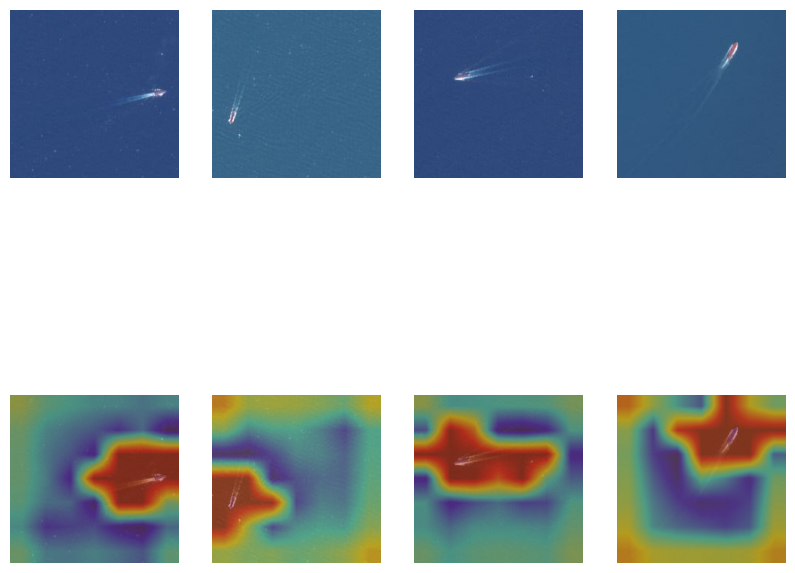

In [58]:
# Create GradCAM
root_path = 'interview_datasets/Sentinel2_partial/Ship/'
paths = [root_path + '0_2_3_id_3214.jpg', root_path + '0_2_3_id_1430.jpg', root_path + '0_2_3_id_3206.jpg', root_path + '0_2_3_id_3401.jpg']

fig, axes = plt.subplots(2, 4, figsize = (10, 10))

for i in range(4):

    # Load and preprocess your input image
    img_path = paths[i]
    img = Image.open(img_path).convert('RGB')

    # Choose the layer to visualize (typically a convolutional layer)

    # Compute the GradCAM heatmap
    heatmap = gradcam(model, img)

    # Resize the heatmap to the original image size
    heatmap = cv2.resize(heatmap, (img.size[0], img.size[1]))

    # Apply a colormap for visualization
    heatmap = (heatmap * 255).astype(np.uint8)
    colormap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    # Superimpose the heatmap on the original image
    superimposed_img = cv2.addWeighted(cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR), 0.6, colormap, 0.4, 0)

    # Display the superimposed image

    axes[0,i].imshow(img)
    axes[0,i].axis('off')
    axes[1,i].imshow(superimposed_img)
    axes[1,i].axis('off')

fig.subplots_adjust(wspace=0.2, hspace=0.0)
plt.show()

In [3]:
# Loading ResNet
model_path = 'weights/Sentinel2/ResNet/model_weights_epoch9.pth.tar'

# Load the model
model_checkpoint = torch.load(model_path, map_location=torch.device('cpu'))

model = resnet50(num_classes = 2)

new_dict = {}
for old_key, new_key in zip(model_checkpoint.keys(), model.state_dict().keys()):
    value = model_checkpoint[old_key]
    new_dict[new_key] = value

model_checkpoint["state_dict"] = OrderedDict(new_dict)
model.load_state_dict(model_checkpoint["state_dict"])

<All keys matched successfully>

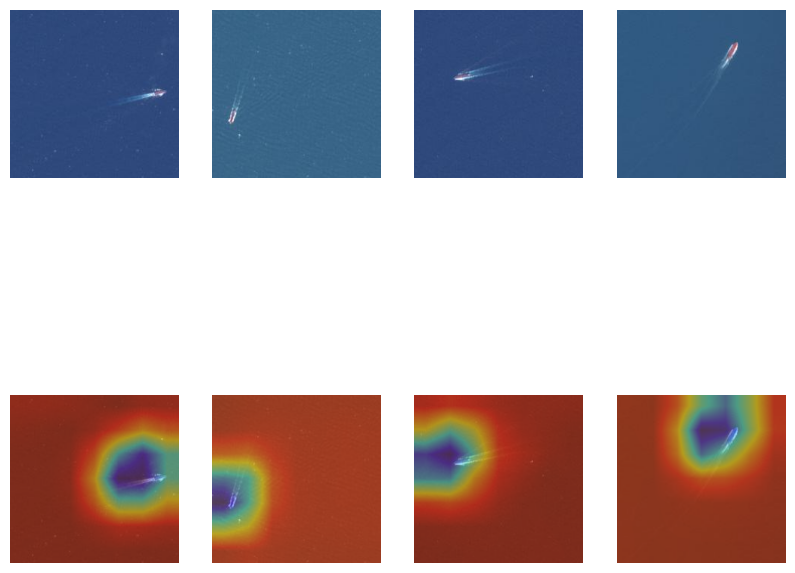

In [4]:
# Create GradCAM
root_path = 'interview_datasets/Sentinel2_partial/Ship/'
paths = [root_path + '0_2_3_id_3214.jpg', root_path + '0_2_3_id_1430.jpg', root_path + '0_2_3_id_3206.jpg', root_path + '0_2_3_id_3401.jpg']

fig, axes = plt.subplots(2, 4, figsize = (10, 10))

for i in range(4):

    # Load and preprocess your input image
    img_path = paths[i]
    img = Image.open(img_path).convert('RGB')

    # Choose the layer to visualize (typically a convolutional layer)

    # Compute the GradCAM heatmap
    heatmap = gradcam(model, img)

    # Resize the heatmap to the original image size
    heatmap = cv2.resize(heatmap, (img.size[0], img.size[1]))

    # Apply a colormap for visualization
    heatmap = (heatmap * 255).astype(np.uint8)
    colormap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    # Superimpose the heatmap on the original image
    superimposed_img = cv2.addWeighted(cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR), 0.6, colormap, 0.4, 0)

    # Display the superimposed image

    axes[0,i].imshow(img)
    axes[0,i].axis('off')
    axes[1,i].imshow(superimposed_img)
    axes[1,i].axis('off')

fig.subplots_adjust(wspace=0.2, hspace=0.0)
plt.show()